# RNN MODEL:-
Recurrent Neural Network Model is a type of Deep Learning Model that is designed to work with sequence data.
Normal Neural Networks examine the data only one time and do not store the past values
But for stock  prediction, the model need to store the past stock values, That is why we use Recurrent Model

In [1]:
# In this notebook we will create Simple RNN Model
# Step 1:- We will load the saved sequences
import numpy as np
data = np.load("../data/tesla_sequences.npz")

# Step 2:- To check if all the sequences are saved and loaded or not
data.files

['X_train_1d',
 'y_train_1d',
 'X_test_1d',
 'y_test_1d',
 'X_train_5d',
 'y_train_5d',
 'X_test_5d',
 'y_test_5d',
 'X_train_10d',
 'y_train_10d',
 'X_test_10d',
 'y_test_10d']

# Building The Model for 1-Day Prediction

In [2]:
# Step 1:- Loading the day 1 prediction sequences
X_train_one = data["X_train_1d"]
y_train_one = data["y_train_1d"]
X_test_one  = data["X_test_1d"]
y_test_one  = data["y_test_1d"]

print(X_train_one.shape, y_train_one.shape) 

# Meaning of X_train shape → (1872, 60, 1). 1872 → Number of training samples. 60 → Number of past days used (WINDOW_SIZE)
# 1 → Number of features (Adj Close price)


# Meaning of y_train shape → (1872, 1, 1). 1872 → Number of training samples. 1 → Forecast horizon (1-day prediction)
# 1 → One output feature (Adj Close)

(1872, 60, 1) (1872, 1, 1)


In [3]:
# Step 2:- Importing Required Libraries
from tensorflow.keras.models import Sequential # Sequential Library builds Neural Network layer by layer in order
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout # Input Library defines the shape of the input
# SimpleRNN Library develops the main recurrent layer which learns from the sequences
# Dense Library develops a fully connected layer used for prediction
# Dropout Library disables few neurons to prevent overfitting
from tensorflow.keras.optimizers import Adam # Adam optimizer adjusts the weights efficiently during the training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # EarlySopping Library stops training when there is no improvement
# ModelCheckpoint Library saves the best model automatically
from scikeras.wrappers import KerasRegressor 
# KerasRegressor is used to wrap the RNN model because GridSearchCV cannot use Keras 
from sklearn.model_selection import GridSearchCV
# GridSearchCV imported to use different parameters



# -------------------------------
# Step 3:- Building The Simple RNN Model
# -------------------------------

def build_simple_rnn_one(units, dropout_rate, learning_rate):

    model_rnn_one = Sequential() # We create an empty neural network model, in which we add layers later on


    # -------------------------------
    # Step 4:- Adding Layers to the Neural Network Model
    # -------------------------------

    model_rnn_one.add(Input(shape=(X_train_one.shape[1], X_train_one.shape[2]))) # Here we add the input shape
    # We already got the output for X_train.shape and y_train.shape = (1872, 60, 1) (1872, 1, 1)
    # So X_train[1] means 60 (No of steps or days) and X_train[2] means 1 (No of features or 1 stock price)

    model_rnn_one.add(SimpleRNN(
        units=units, # The model will have memory cells to learn pattern
        activation='tanh' # Helps the model learn non-linear patterns like trends from past prices
    ))


    model_rnn_one.add(Dropout(dropout_rate)) # Here we add the dropout layer which disables neurons to avoid overfitting

    model_rnn_one.add(Dense(y_train_one.shape[1])) # This is the final layer which shows prediction
    # y_train[1] means 1 (output like 1-day, 5-days or 10-days)



    # -------------------------------
    # Step 5:- Compiling The Model
    # -------------------------------
    model_rnn_one.compile(
        optimizer=Adam(learning_rate=learning_rate), # Controls how fast the Model Learns
        loss='mean_squared_error' # Measures the prediction error 
    )
    return model_rnn_one


# -------------------------------
# Step 6:- Wrapping the model in Keras Regressor
# -------------------------------
rnn_regressor_one = KerasRegressor(
    model=build_simple_rnn_one,   
    epochs=20,
    batch_size=32,
    verbose=0
)

# -------------------------------
# Step 7:- Create Grid Parameters
# -------------------------------
param_grid = {
    'model__units': [32, 50, 64],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0005]
}



# -------------------------------
# Step 8:- Apply Grid Search
# -------------------------------
grid_search_one = GridSearchCV(
    estimator=rnn_regressor_one,
    param_grid=param_grid,
    cv=3
)

# This step is necessary because Grid expects 2-D object, but y_train is 3-D object
# So here we convert y_train from 2-D to 3-D object
y_train_one = y_train_one.reshape(y_train_one.shape[0], y_train_one.shape[1])


grid_search_one.fit(X_train_one, y_train_one)


print("Best Hyperparameters for SimpleRNN:")
print(grid_search_one.best_params_)

print("Best MSE Score:")
print(-grid_search_one.best_score_)

# -------------------------------
# Step 9:- Return the Best Parameters
# -------------------------------
best_params_one = grid_search_one.best_params_


# -------------------------------
# Step 10:- Create the Final Model
# -------------------------------
final_rnn_model_one = build_simple_rnn_one(
    units=best_params_one['model__units'],
    dropout_rate=best_params_one['model__dropout_rate'],
    learning_rate=best_params_one['model__learning_rate']
)

final_rnn_model_one.summary() # This will print the model structure


# -------------------------------
# Step 11:- Creating Callbacks 
# -------------------------------
# EarlyStopping will stop the training if there is no improve in validation loss after 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# -------------------------------
# Step 12:- Saving the Best Model
# -------------------------------
model_checkpoint = ModelCheckpoint(
    filepath="../models/simple_rnn_best_model_one.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)



# -------------------------------
# Step 13:- Training The Model
# -------------------------------
history_rnn_one = final_rnn_model_one.fit(
    X_train_one, y_train_one,
    validation_data=(X_test_one, y_test_one),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)


print('Trainig of RNN Model for 1-Day is completed')

2026-01-12 00:00:32.006985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 00:00:36.251372: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Best Hyperparameters for SimpleRNN:
{'model__dropout_rate': 0.2, 'model__learning_rate': 0.0005, 'model__units': 50}
Best MSE Score:
-0.8398051448131194


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_37 (SimpleRNN)       │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Trainig of RNN Model for 1-Day is completed


# SimpleRNN Model Summary – The Project Will Predict the Stock Price One-Day into the Future

This SimpleRNN model is designed to predict the next day’s Tesla stock closing price using the past 60 days of data.

SimpleRNN Layer (50 units)
This is the core layer of the model. It reads the stock prices one day at a time, remembers useful patterns from previous days, and learns trends over time.
It has 2,651 trainable parameters, which include weights for learning from past and current values.

Dropout Layer (20%)
This layer randomly disables some neurons during training.
Its purpose is to prevent overfitting, so the model does not memorize the data and can perform better on new, unseen data.

Dense Output Layer (1 neuron)
This final layer produces one output value, which is the predicted closing price for the next day.
It has 2,600 parameters, connecting the learned features to the final prediction.

Total Parameters: 2,651
These are the values the model learns during training.
All parameters are trainable, meaning the model adjusts them to minimize prediction error.

Overall, this SimpleRNN model is lightweight, efficient, and suitable as a baseline model for time-series prediction, but it may struggle with long-term dependencies—hence the need for LSTM in later stages.

# Building the Model for 5-Day Prediction

In [4]:
# Step 1:- Loading the day 5 prediction sequences
X_train_five = data["X_train_5d"]
y_train_five = data["y_train_5d"]
X_test_five  = data["X_test_5d"]
y_test_five  = data["y_test_5d"]

print(X_train_five.shape, y_train_five.shape) 

(1868, 60, 1) (1868, 5, 1)


In [5]:
# -------------------------------
# Step 2:- Building The Simple RNN Model
# -------------------------------

def build_simple_rnn_five(units, dropout_rate, learning_rate):

    model_rnn_five = Sequential() # We create an empty neural network model, in which we add layers later on


    # -------------------------------
    # Step 3:- Adding Layers to the Neural Network Model
    # -------------------------------

    model_rnn_five.add(Input(shape=(X_train_five.shape[1], X_train_five.shape[2]))) # Here we add the input shape
    # We already got the output for X_train.shape and y_train.shape = (1872, 60, 1) (1872, 1, 1)
    # So X_train[1] means 60 (No of steps or days) and X_train[2] means 1 (No of features or 1 stock price)

    model_rnn_five.add(SimpleRNN(
        units=units, # The model will have memory cells to learn pattern
        activation='tanh' # Helps the model learn non-linear patterns like trends from past prices
    ))


    model_rnn_five.add(Dropout(dropout_rate)) # Here we add the dropout layer which disables neurons to avoid overfitting

    model_rnn_five.add(Dense(y_train_five.shape[1])) # This is the final layer which shows prediction
    # y_train[1] means 1 (output like 1-day, 5-days or 10-days)



    # -------------------------------
    # Step 4:- Compiling The Model
    # -------------------------------
    model_rnn_five.compile(
        optimizer=Adam(learning_rate=learning_rate), # Controls how fast the Model Learns
        loss='mean_squared_error' # Measures the prediction error 
    )
    return model_rnn_five


# -------------------------------
# Step 5:- Wrapping the model in Keras Regressor
# -------------------------------
rnn_regressor_five = KerasRegressor(
    model=build_simple_rnn_five,   
    epochs=20,
    batch_size=32,
    verbose=0
)



# -------------------------------
# Step 6:- Apply Grid Search
# -------------------------------
grid_search_five = GridSearchCV(
    estimator=rnn_regressor_five,
    param_grid=param_grid,
    cv=3
)

# This step is necessary because Grid expects 2-D object, but y_train is 3-D object
# So here we convert y_train from 2-D to 3-D object
y_train_five = y_train_five.reshape(y_train_five.shape[0], y_train_five.shape[1])


grid_search_five.fit(X_train_five, y_train_five)


print("Best Hyperparameters for SimpleRNN:")
print(grid_search_five.best_params_)

print("Best MSE Score:")
print(-grid_search_five.best_score_)

# -------------------------------
# Step 7:- Return the Best Parameters
# -------------------------------
best_params_five = grid_search_five.best_params_


# -------------------------------
# Step 8:- Create the Final Model
# -------------------------------
final_rnn_model_five = build_simple_rnn_five(
    units=best_params_five['model__units'],
    dropout_rate=best_params_five['model__dropout_rate'],
    learning_rate=best_params_five['model__learning_rate']
)

final_rnn_model_five.summary() # This will print the model structure


# -------------------------------
# Step 9:- Saving the Best Model
# -------------------------------
model_checkpoint = ModelCheckpoint(
    filepath="../models/simple_rnn_best_model_five.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)



# -------------------------------
# Step 10:- Training The Model
# -------------------------------
history_rnn_five = final_rnn_model_five.fit(
    X_train_five, y_train_five,
    validation_data=(X_test_five, y_test_five),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)


print('Trainig of RNN Model for 5-Day is completed')

Best Hyperparameters for SimpleRNN:
{'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__units': 64}
Best MSE Score:
-0.43134952581750535


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_75 (SimpleRNN)       │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,549 (17.77 KB)

 Trainable params: 4,549 (17.77 KB)

 Non-trainable params: 0 (0.00 B)

Trainig of RNN Model for 5-Day is completed


# SimpleRNN Model Summary – The Project Will Predict the Stock Price Five-Days into the Future

This SimpleRNN model is designed to predict the next 5 day’s Tesla stock closing price using the past 60 days of data.

SimpleRNN Layer (50 units)
This is the core layer of the model. It reads the stock prices one day at a time, remembers useful patterns from previous days, and learns trends over time.
It has 2,855 trainable parameters, which include weights for learning from past and current values.

Dropout Layer (20%)
This layer randomly disables some neurons during training.
Its purpose is to prevent overfitting, so the model does not memorize the data and can perform better on new, unseen data.

Dense Output Layer (5 neurons)
This final layer produces one output value, which is the predicted closing price for the next day.
It has 2,600 parameters, connecting the learned features to the final prediction.

Total Parameters: 2,855
These are the values the model learns during training.
All parameters are trainable, meaning the model adjusts them to minimize prediction error.

Overall, this SimpleRNN model is lightweight, efficient, and suitable as a baseline model for time-series prediction, but it may struggle with long-term dependencies—hence the need for LSTM in later stages.

# Building the Model for 10-Day Prediction

In [6]:
# Step 1:- Loading the day 10 prediction sequences
X_train_ten = data["X_train_10d"]
y_train_ten = data["y_train_10d"]
X_test_ten  = data["X_test_10d"]
y_test_ten  = data["y_test_10d"]

print(X_train_ten.shape, y_train_ten.shape) 

(1863, 60, 1) (1863, 10, 1)


In [7]:
# -------------------------------
# Step 2:- Building The Simple RNN Model
# -------------------------------

def build_simple_rnn_ten(units, dropout_rate, learning_rate):

    model_rnn_ten = Sequential() # We create an empty neural network model, in which we add layers later on


    # -------------------------------
    # Step 3:- Adding Layers to the Neural Network Model
    # -------------------------------

    model_rnn_ten.add(Input(shape=(X_train_ten.shape[1], X_train_ten.shape[2]))) # Here we add the input shape
    # We already got the output for X_train.shape and y_train.shape = (1872, 60, 1) (1872, 1, 1)
    # So X_train[1] means 60 (No of steps or days) and X_train[2] means 1 (No of features or 1 stock price)

    model_rnn_ten.add(SimpleRNN(
        units=units, # The model will have memory cells to learn pattern
        activation='tanh' # Helps the model learn non-linear patterns like trends from past prices
    ))


    model_rnn_ten.add(Dropout(dropout_rate)) # Here we add the dropout layer which disables neurons to avoid overfitting

    model_rnn_ten.add(Dense(y_train_ten.shape[1])) # This is the final layer which shows prediction
    # y_train[1] means 1 (output like 1-day, 5-days or 10-days)



    # -------------------------------
    # Step 4:- Compiling The Model
    # -------------------------------
    model_rnn_ten.compile(
        optimizer=Adam(learning_rate=learning_rate), # Controls how fast the Model Learns
        loss='mean_squared_error' # Measures the prediction error 
    )
    return model_rnn_ten


# -------------------------------
# Step 5:- Wrapping the model in Keras Regressor
# -------------------------------
rnn_regressor_ten = KerasRegressor(
    model=build_simple_rnn_ten,   
    epochs=20,
    batch_size=32,
    verbose=0
)



# -------------------------------
# Step 6:- Apply Grid Search
# -------------------------------
grid_search_ten = GridSearchCV(
    estimator=rnn_regressor_ten,
    param_grid=param_grid,
    cv=3
)

# This step is necessary because Grid expects 2-D object, but y_train is 3-D object
# So here we convert y_train from 2-D to 3-D object
y_train_ten = y_train_ten.reshape(y_train_ten.shape[0], y_train_ten.shape[1])


grid_search_ten.fit(X_train_ten, y_train_ten)


print("Best Hyperparameters for SimpleRNN:")
print(grid_search_ten.best_params_)

print("Best MSE Score:")
print(-grid_search_ten.best_score_)

# -------------------------------
# Step 7:- Return the Best Parameters
# -------------------------------
best_params_ten = grid_search_ten.best_params_


# -------------------------------
# Step 8:- Create the Final Model
# -------------------------------
final_rnn_model_ten = build_simple_rnn_ten(
    units=best_params_ten['model__units'],
    dropout_rate=best_params_ten['model__dropout_rate'],
    learning_rate=best_params_ten['model__learning_rate']
)

final_rnn_model_ten.summary() # This will print the model structure


# -------------------------------
# Step 9:- Saving the Best Model
# -------------------------------
model_checkpoint = ModelCheckpoint(
    filepath="../models/simple_rnn_best_model_ten.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)



# -------------------------------
# Step 10:- Training The Model
# -------------------------------
history_rnn_ten = final_rnn_model_ten.fit(
    X_train_ten, y_train_ten,
    validation_data=(X_test_ten, y_test_ten),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=0
)


print('Trainig of RNN Model for 10-Day is completed')

Best Hyperparameters for SimpleRNN:
{'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__units': 64}
Best MSE Score:
0.2625618692277888


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_113 (SimpleRNN)      │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,874 (19.04 KB)

 Trainable params: 4,874 (19.04 KB)

 Non-trainable params: 0 (0.00 B)

Trainig of RNN Model for 10-Day is completed


# SimpleRNN Model Summary – The Project Will Predict the Stock Price Ten-Days into the Future

This SimpleRNN model is designed to predict the next 10 day’s Tesla stock closing price using the past 60 days of data.

SimpleRNN Layer (64 units)
This is the core layer of the model. It reads the stock prices one day at a time, remembers useful patterns from previous days, and learns trends over time.
It has 4,874 trainable parameters, which include weights for learning from past and current values.

Dropout Layer (20%)
This layer randomly disables some neurons during training.
Its purpose is to prevent overfitting, so the model does not memorize the data and can perform better on new, unseen data.

Dense Output Layer (10 neurons)
This final layer produces one output value, which is the predicted closing price for the next day.
It has 4,224 parameters, connecting the learned features to the final prediction.

Total Parameters: 4.874
These are the values the model learns during training.
All parameters are trainable, meaning the model adjusts them to minimize prediction error.

Overall, this SimpleRNN model is lightweight, efficient, and suitable as a baseline model for time-series prediction, but it may struggle with long-term dependencies—hence the need for LSTM in later stages.

# Model Evaluation

In [8]:
# -------------------------------
# Step 1:- Predict on Test Set
# -------------------------------
y_pred_one = final_rnn_model_one.predict(X_test_one)
y_pred_five = final_rnn_model_five.predict(X_test_five)
y_pred_ten = final_rnn_model_ten.predict(X_test_ten)


# Ensure both actual and predicted values are 2D for 1-Day
y_test_eval_one = y_test_one.reshape(y_test_one.shape[0], y_test_one.shape[1])
y_pred_eval_one = y_pred_one.reshape(y_pred_one.shape[0], y_pred_one.shape[1])


print("Prediction Shape:", y_pred_eval_one.shape)
print("Actual Shape:", y_test_eval_one.shape)


print('---------------------------')

# Ensure both actual and predicted values are 2D for 5-Days
y_test_eval_five = y_test_five.reshape(y_test_five.shape[0], y_test_five.shape[1])
y_pred_eval_five = y_pred_five.reshape(y_pred_five.shape[0], y_pred_five.shape[1])


print("Prediction Shape:", y_pred_eval_five.shape)
print("Actual Shape:", y_test_eval_five.shape)


print('---------------------------')

# Ensure both actual and predicted values are 2D for 10-Days
y_test_eval_ten = y_test_ten.reshape(y_test_ten.shape[0], y_test_ten.shape[1])
y_pred_eval_ten = y_pred_ten.reshape(y_pred_ten.shape[0], y_pred_ten.shape[1])


print("Prediction Shape:", y_pred_eval_ten.shape)
print("Actual Shape:", y_test_eval_ten.shape)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction Shape: (424, 1)
Actual Shape: (424, 1)
---------------------------
Prediction Shape: (420, 5)
Actual Shape: (420, 5)
---------------------------
Prediction Shape: (415, 10)
Actual Shape: (415, 10)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 2: Function to Evaluate Forecast (1-day, 5-day, 10-day)
def evaluate_forecast(day, y_true, y_pred):
    """
    day: which day to evaluate (1, 5, 10)
    """
    index = day - 1  # Convert day to index

    actual = y_true[:, index] # We apply y_true for the particular day (1, 5 or 10)
    predicted = y_pred[:, index] # We apply y_pred for the particular day (1, 5 or 10)

    mse = mean_squared_error(actual, predicted) # We calculate the mean squared error
    rmse = np.sqrt(mse) # We calculate the square root of the mean squared error
    mae = mean_absolute_error(actual, predicted) # We calculate the mean absolute error

    print(f"\nEvaluation for {day}-Day Forecast:")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")

    return actual, predicted

# Step 3: Evaluate 1-Day, 5-Day, and 10-Day Forecasts
actual_1, pred_1 = evaluate_forecast(1, y_test_eval_one, y_pred_eval_one)
actual_5, pred_5 = evaluate_forecast(5, y_test_eval_five, y_pred_eval_five)
actual_10, pred_10 = evaluate_forecast(10, y_test_eval_ten, y_pred_eval_ten)


Evaluation for 1-Day Forecast:
MSE  : 0.0022
RMSE : 0.0466
MAE  : 0.0285

Evaluation for 5-Day Forecast:
MSE  : 0.0157
RMSE : 0.1252
MAE  : 0.0977

Evaluation for 10-Day Forecast:
MSE  : 0.0719
RMSE : 0.2682
MAE  : 0.2068


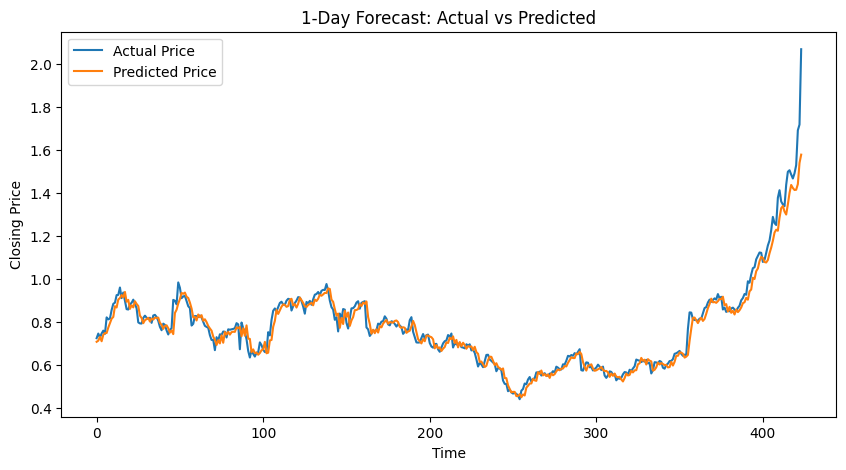

In [10]:
# Step 4: Plot Actual vs Predicted Prices for One-Day
plt.figure(figsize=(10, 5))
plt.plot(actual_1, label='Actual Price')
plt.plot(pred_1, label='Predicted Price')
plt.title('1-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

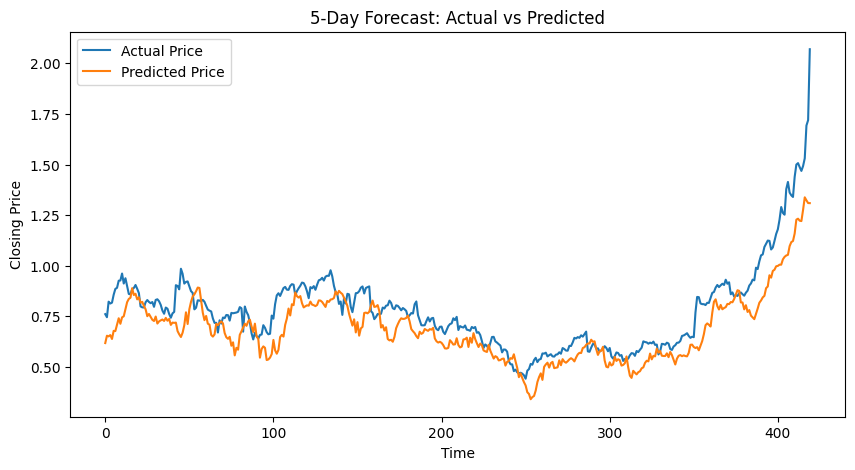

In [11]:
# Step 5: Plot Actual vs Predicted Prices for Five-Days
plt.figure(figsize=(10, 5))
plt.plot(actual_5, label='Actual Price')
plt.plot(pred_5, label='Predicted Price')
plt.title('5-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

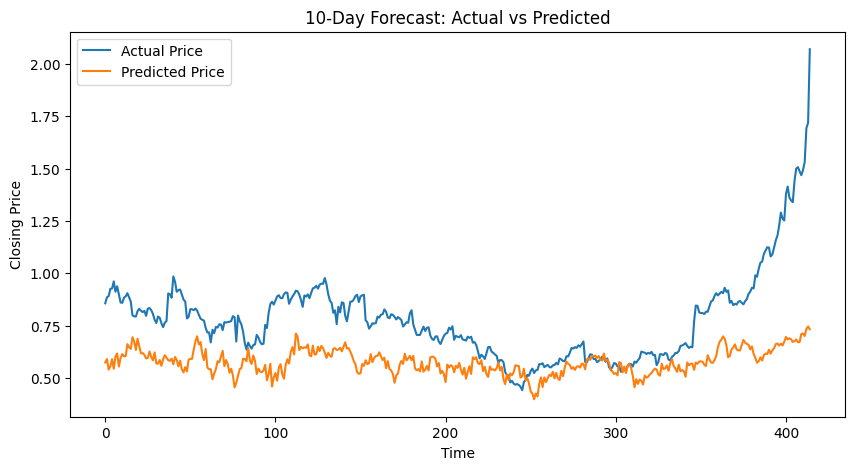

In [12]:
# Step 6: Plot Actual vs Predicted Prices for Ten-Days
plt.figure(figsize=(10, 5))
plt.plot(actual_10, label='Actual Price')
plt.plot(pred_10, label='Predicted Price')
plt.title('10-Day Forecast: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()